### 1.Importing the packages and the 20 News Groups dataset.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import re, numpy as np, pandas as pd
from pprint import pprint
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import sys


# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

C:\Users\b16z\Anaconda3\envs\deeplearning\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\b16z\Anaconda3\envs\deeplearning\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### 2.Import the news groups dataset and retain only 4 of the target_names categories.

In [2]:
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')

In [3]:
df.head(5)

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc


In [4]:
df = df.loc[df.target_names.isin(['soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast', 'rec.motorcycles']) , :]
print(df.shape)  #> (2361, 3)
df.head()

(2361, 3)


,content,target,target_names
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
10007,From: jet@netcom.Netcom.COM (J. Eric Townsend)...,8,rec.motorcycles
10008,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...,10,rec.sport.hockey
10017,From: nstramer@supergas.dazixco.ingr.com (Naft...,17,talk.politics.mideast
10019,From: mussack@austin.ibm.com (Christopher Muss...,15,soc.religion.christian


### 3.Removing the emails, new line characters, single quotes and finally split the sentence into a list of words using gensim’s simple_preprocess(). Setting the deacc=True option removes punctuations.

In [5]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.content.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])
# [['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', ...trucated...]]

[['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', 'organization', 'computrac', 'inc', 'richardson', 'tx', 'keywords', 'ducati', 'gts', 'how', 'much', 'lines', 'have', 'line', 'on', 'ducati', 'gts', 'model', 'with', 'on', 'the', 'clock', 'runs', 'very', 'well', 'paint', 'is', 'the', 'bronze', 'brown', 'orange', 'faded', 'out', 'leaks', 'bit', 'of', 'oil', 'and', 'pops', 'out', 'of', 'st', 'with', 'hard', 'accel', 'the', 'shop', 'will', 'fix', 'trans', 'and', 'oil', 'leak', 'they', 'sold', 'the', 'bike', 'to', 'the', 'and', 'only', 'owner', 'they', 'want', 'and', 'am', 'thinking', 'more', 'like', 'any', 'opinions', 'out', 'there', 'please', 'email', 'me', 'thanks', 'it', 'would', 'be', 'nice', 'stable', 'mate', 'to', 'the', 'beemer', 'then', 'ill', 'get', 'jap', 'bike', 'and', 'call', 'myself', 'axis', 'motors', 'tuba', 'irwin', 'honk', 'therefore', 'am', 'computrac', 'r

### 4.Build the Bigram, Trigram Models and Lemmatize

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

C:\Users\b16z\Anaconda3\envs\deeplearning\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


### 5.Build the Topic Model

In [7]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())
#> [(0,
#>   '0.017*"write" + 0.015*"people" + 0.014*"organization" + 0.014*"article" + '
#>   '0.013*"time" + 0.008*"give" + 0.008*"first" + 0.007*"tell" + 0.007*"new" + '
#>   '0.007*"question"'),
#>  (1,
#>   '0.008*"christian" + 0.008*"believe" + 0.007*"god" + 0.007*"law" + '
#>   '0.006*"state" + 0.006*"israel" + 0.006*"israeli" + 0.005*"exist" + '
#>   '0.005*"way" + 0.004*"bible"'),
#>  (2,
#>   '0.024*"armenian" + 0.012*"bike" + 0.006*"kill" + 0.006*"work" + '
#>   '0.005*"well" + 0.005*"year" + 0.005*"sumgait" + 0.005*"soldier" + '
#>   '0.004*"way" + 0.004*"ride"'),
#>  (3,
#>   '0.019*"team" + 0.019*"game" + 0.013*"hockey" + 0.010*"player" + '
#>   '0.009*"play" + 0.009*"win" + 0.009*"nhl" + 0.009*"year" + 0.009*"hawk" + '
#>   '0.009*"season"')]

[(0,
  '0.021*"armenian" + 0.011*"israel" + 0.010*"israeli" + 0.007*"people" + '
  '0.007*"state" + 0.006*"article" + 0.006*"government" + 0.006*"kill" + '
  '0.006*"turk" + 0.005*"genocide"'),
 (1,
  '0.009*"people" + 0.009*"god" + 0.007*"christian" + 0.007*"believe" + '
  '0.006*"write" + 0.006*"question" + 0.006*"law" + 0.005*"book" + '
  '0.005*"organization" + 0.005*"claim"'),
 (2,
  '0.020*"team" + 0.020*"game" + 0.014*"hockey" + 0.011*"nhl" + 0.010*"player" '
  '+ 0.010*"play" + 0.010*"win" + 0.009*"hawk" + 0.009*"season" + '
  '0.008*"year"'),
 (3,
  '0.011*"organization" + 0.011*"write" + 0.010*"article" + 0.008*"time" + '
  '0.008*"bike" + 0.008*"look" + 0.007*"well" + 0.007*"new" + 0.006*"tell" + '
  '0.005*"start"')]


### 6.Finding the Dominant topic and its percentage contribution in each document

In [8]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.8896,"organization, write, article, time, bike, look...","[irwin, arnstein, recommendation, duc, summary..."
1,1,3.0,0.6786,"organization, write, article, time, bike, look...","[eric, townsend, insurance, lotsa_point, reply..."
2,2,2.0,0.4730,"team, game, hockey, nhl, player, play, win, ha...","[gary_dare, reply, gary_dare, organization, ph..."
3,3,0.0,0.6224,"armenian, israel, israeli, people, state, arti...","[naftaly_stramer, peace_talk, reply, organizat..."
4,4,1.0,0.7288,"people, god, christian, believe, write, questi...","[question, authority, trendy, liberal, feminis..."
5,5,1.0,0.5222,"people, god, christian, believe, write, questi...","[harrasse, work, prayer, reply, organization, ..."
6,6,3.0,0.8505,"organization, write, article, time, bike, look...","[andrew_infante, little_hasty, organization, d..."
7,7,1.0,0.8778,"people, god, christian, believe, write, questi...","[james_sledd, afterlife, organization, social,..."
8,8,2.0,0.5051,"team, game, hockey, nhl, player, play, win, ha...","[canadien, stanley_cup, organization, canada, ..."
9,9,2.0,0.7739,"team, game, hockey, nhl, player, play, win, ha...","[steve_gallichio, possible, canadian, wc, team..."


### 7. Finding the most representative sentence for each topic

In [9]:
#Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9927,"armenian, israel, israeli, people, state, article, government, kill, turk, genocide","[serdar_argic, armenian, genocide, muslim, people, article, zuma, reply, article, panos_tamamidi..."
1,1.0,0.9907,"people, god, christian, believe, write, question, law, book, organization, claim","[arrogance, christian, organization, australia, article, mark_baker, write, reasonable, statemen..."
2,2.0,0.9977,"team, game, hockey, nhl, player, play, win, hawk, season, year","[bryan, strouse, nhl, result, game, play, organization, keyword, thursday, night, boxscore, nhl,..."
3,3.0,0.9947,"organization, write, article, time, bike, look, well, new, tell, start","[denis, concordel, sale, husqvarna, te, distribution, ba, ca, organization, apply, biosystem, in..."


### 8. Frequency Distribution of Word Counts in Documents

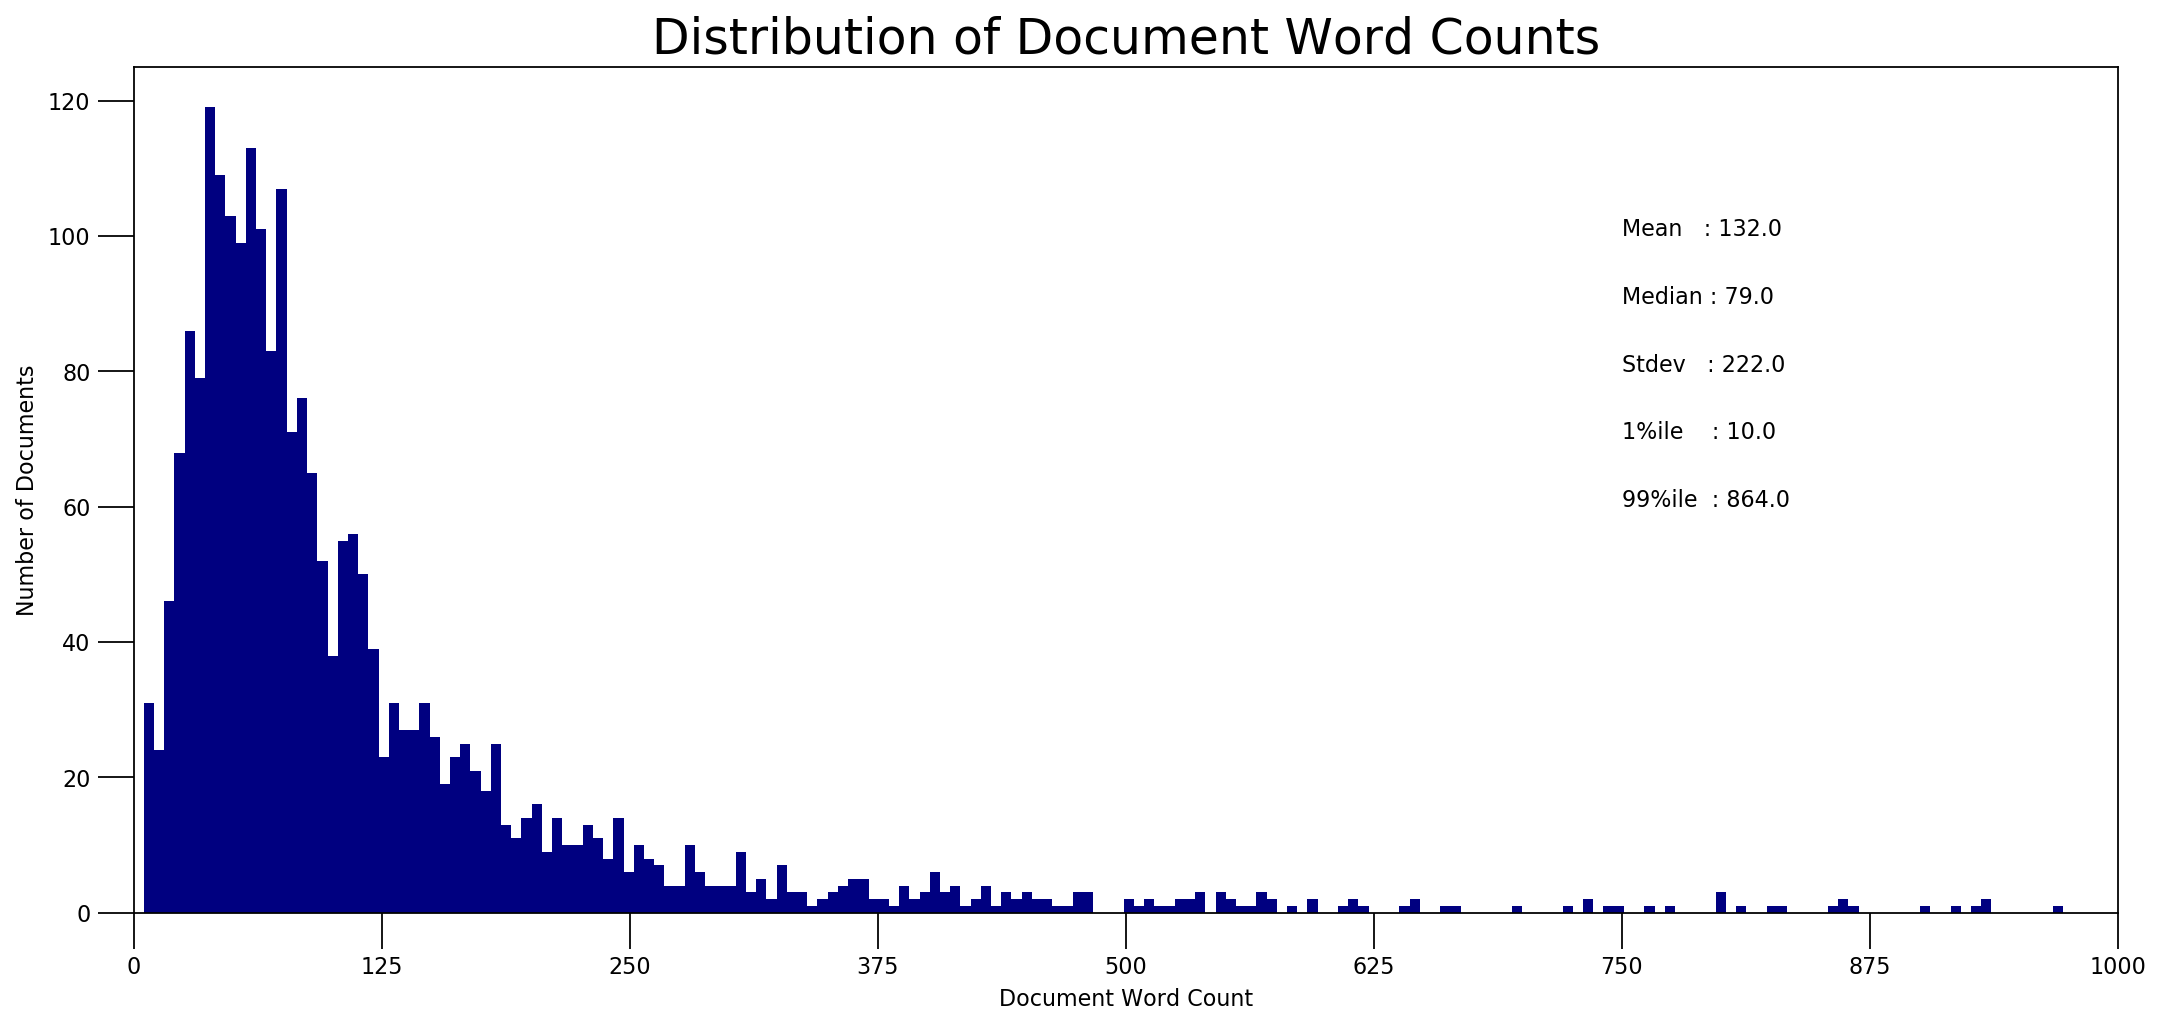

In [10]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

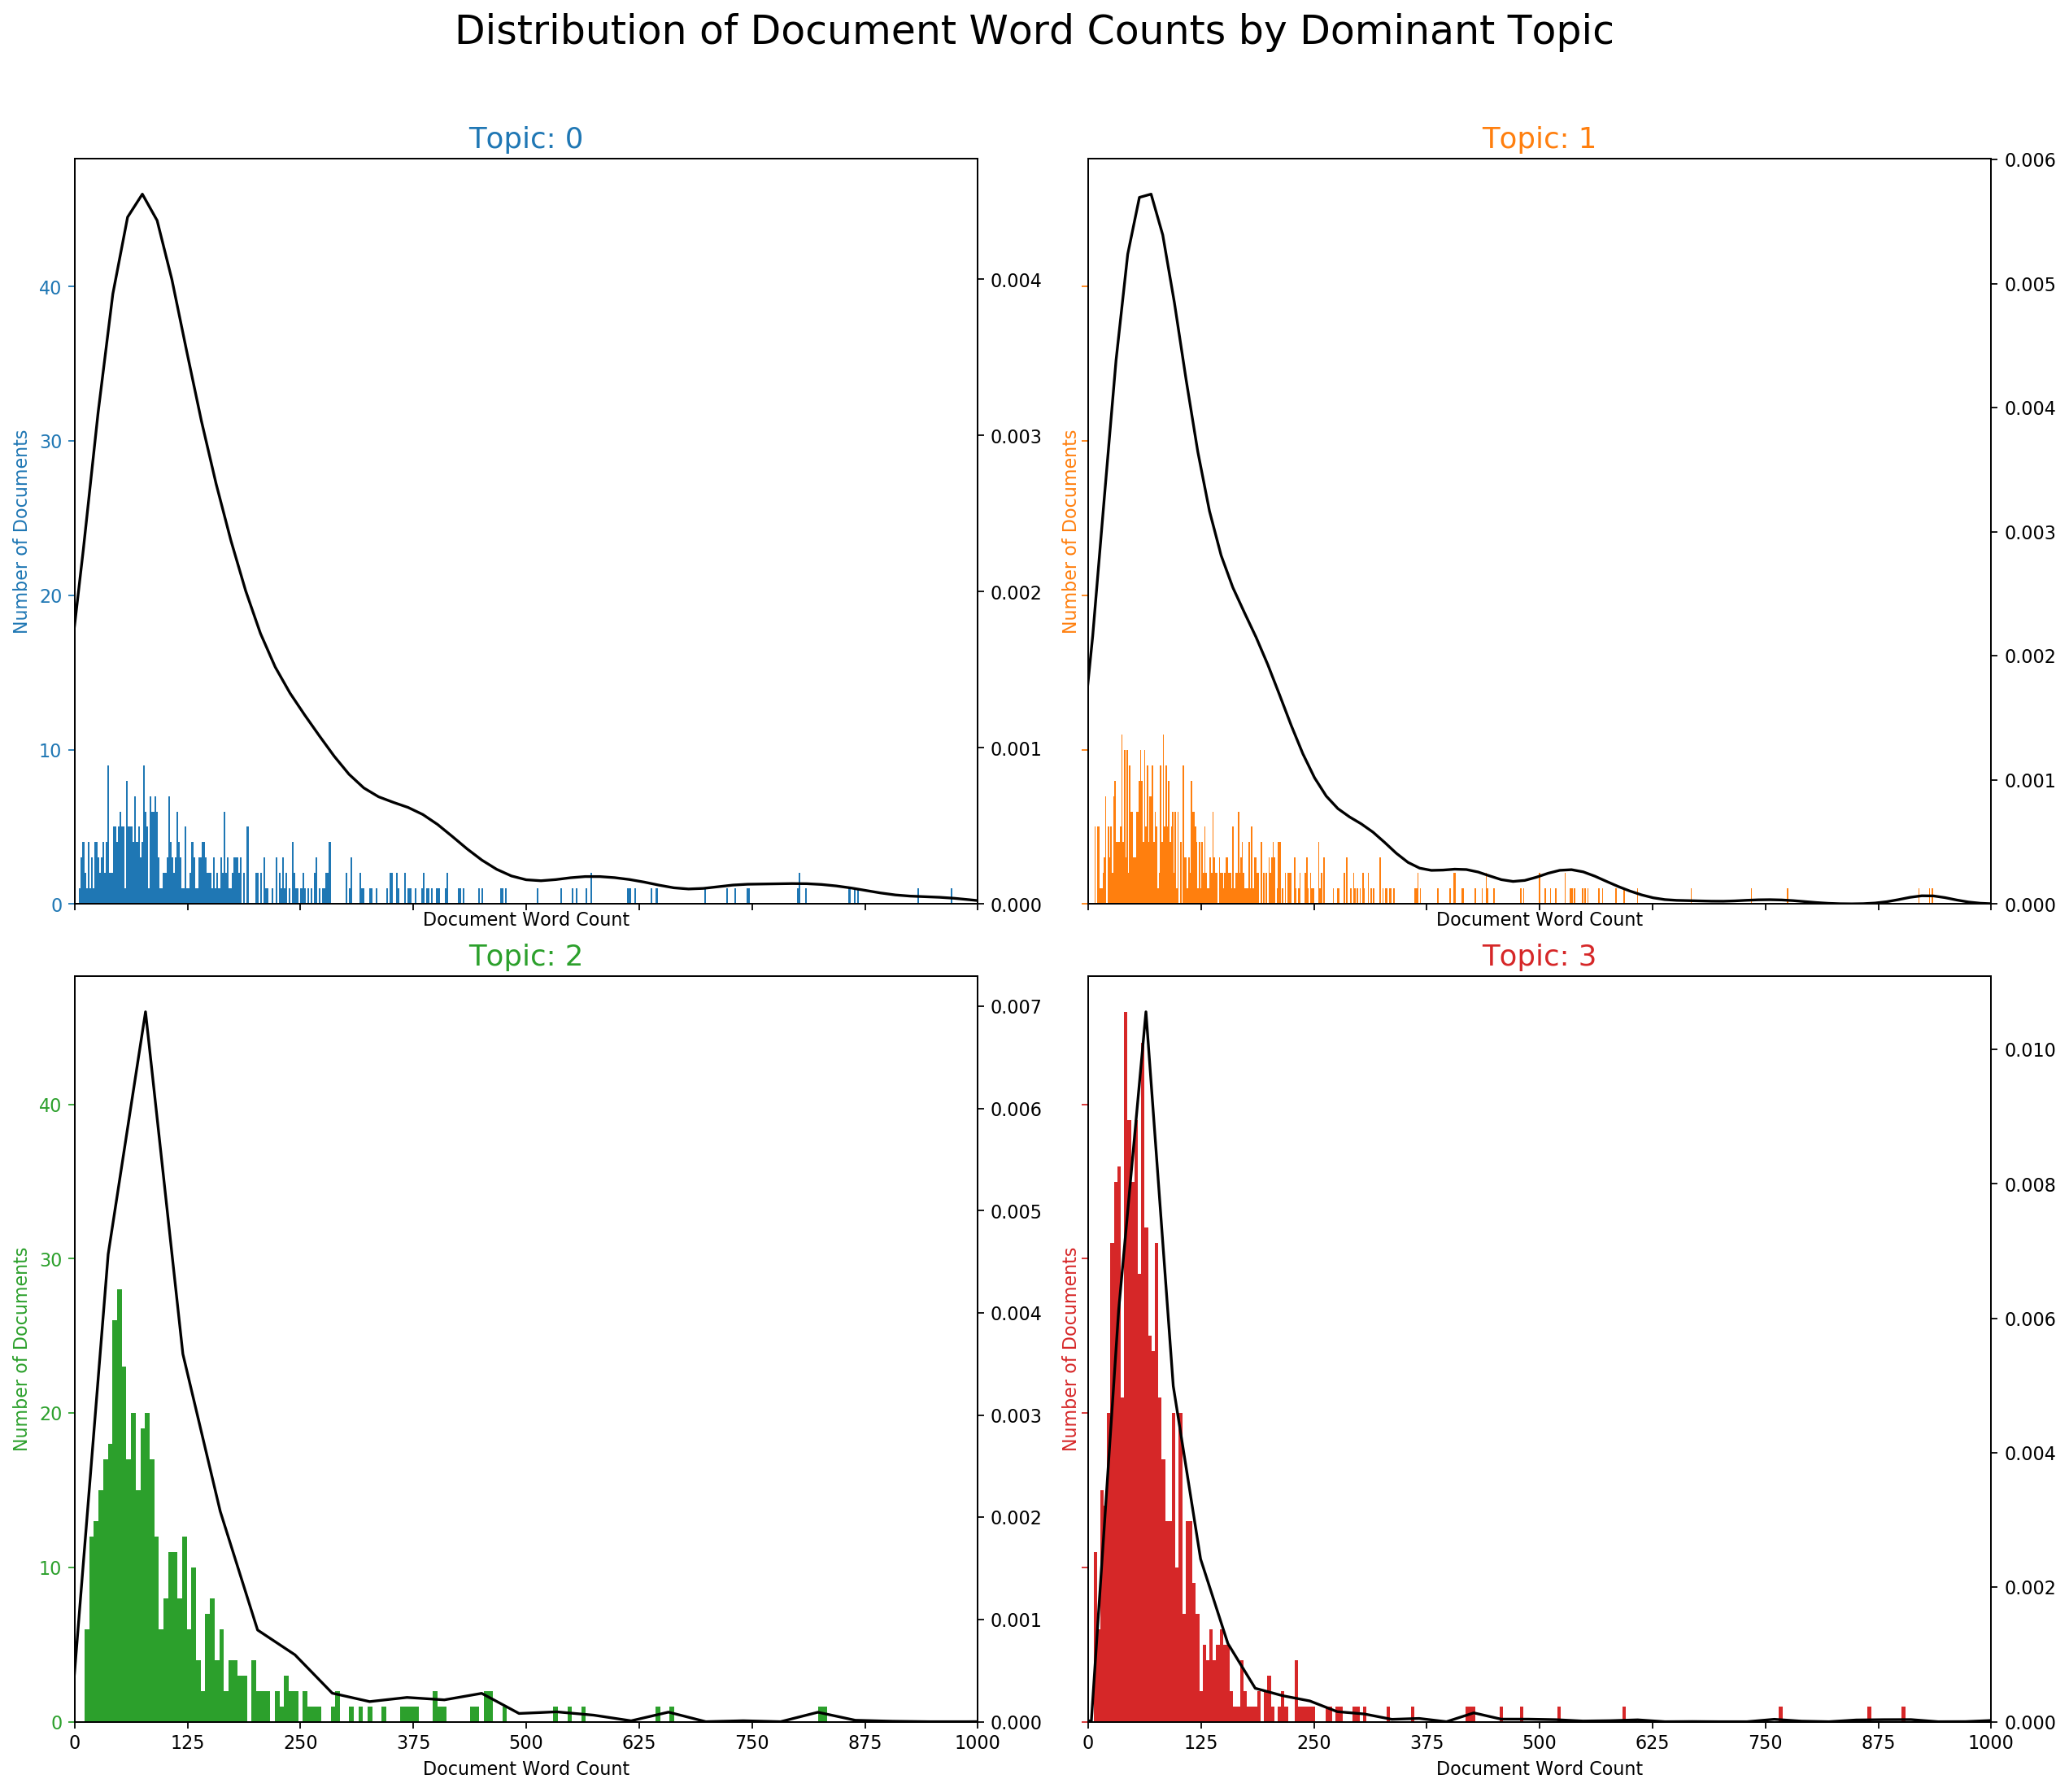

In [11]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

### 9. Word Clouds of Top N Keywords in Each Topic

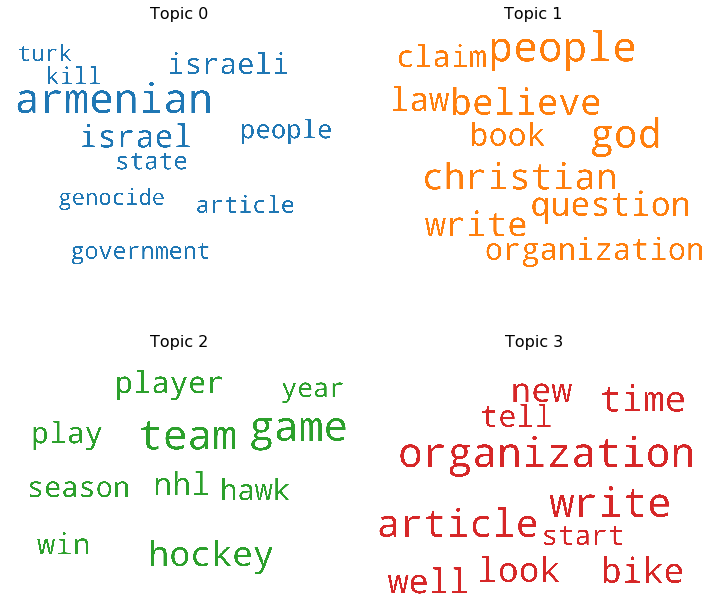

In [13]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### 10. Word Counts of Topic Keywords

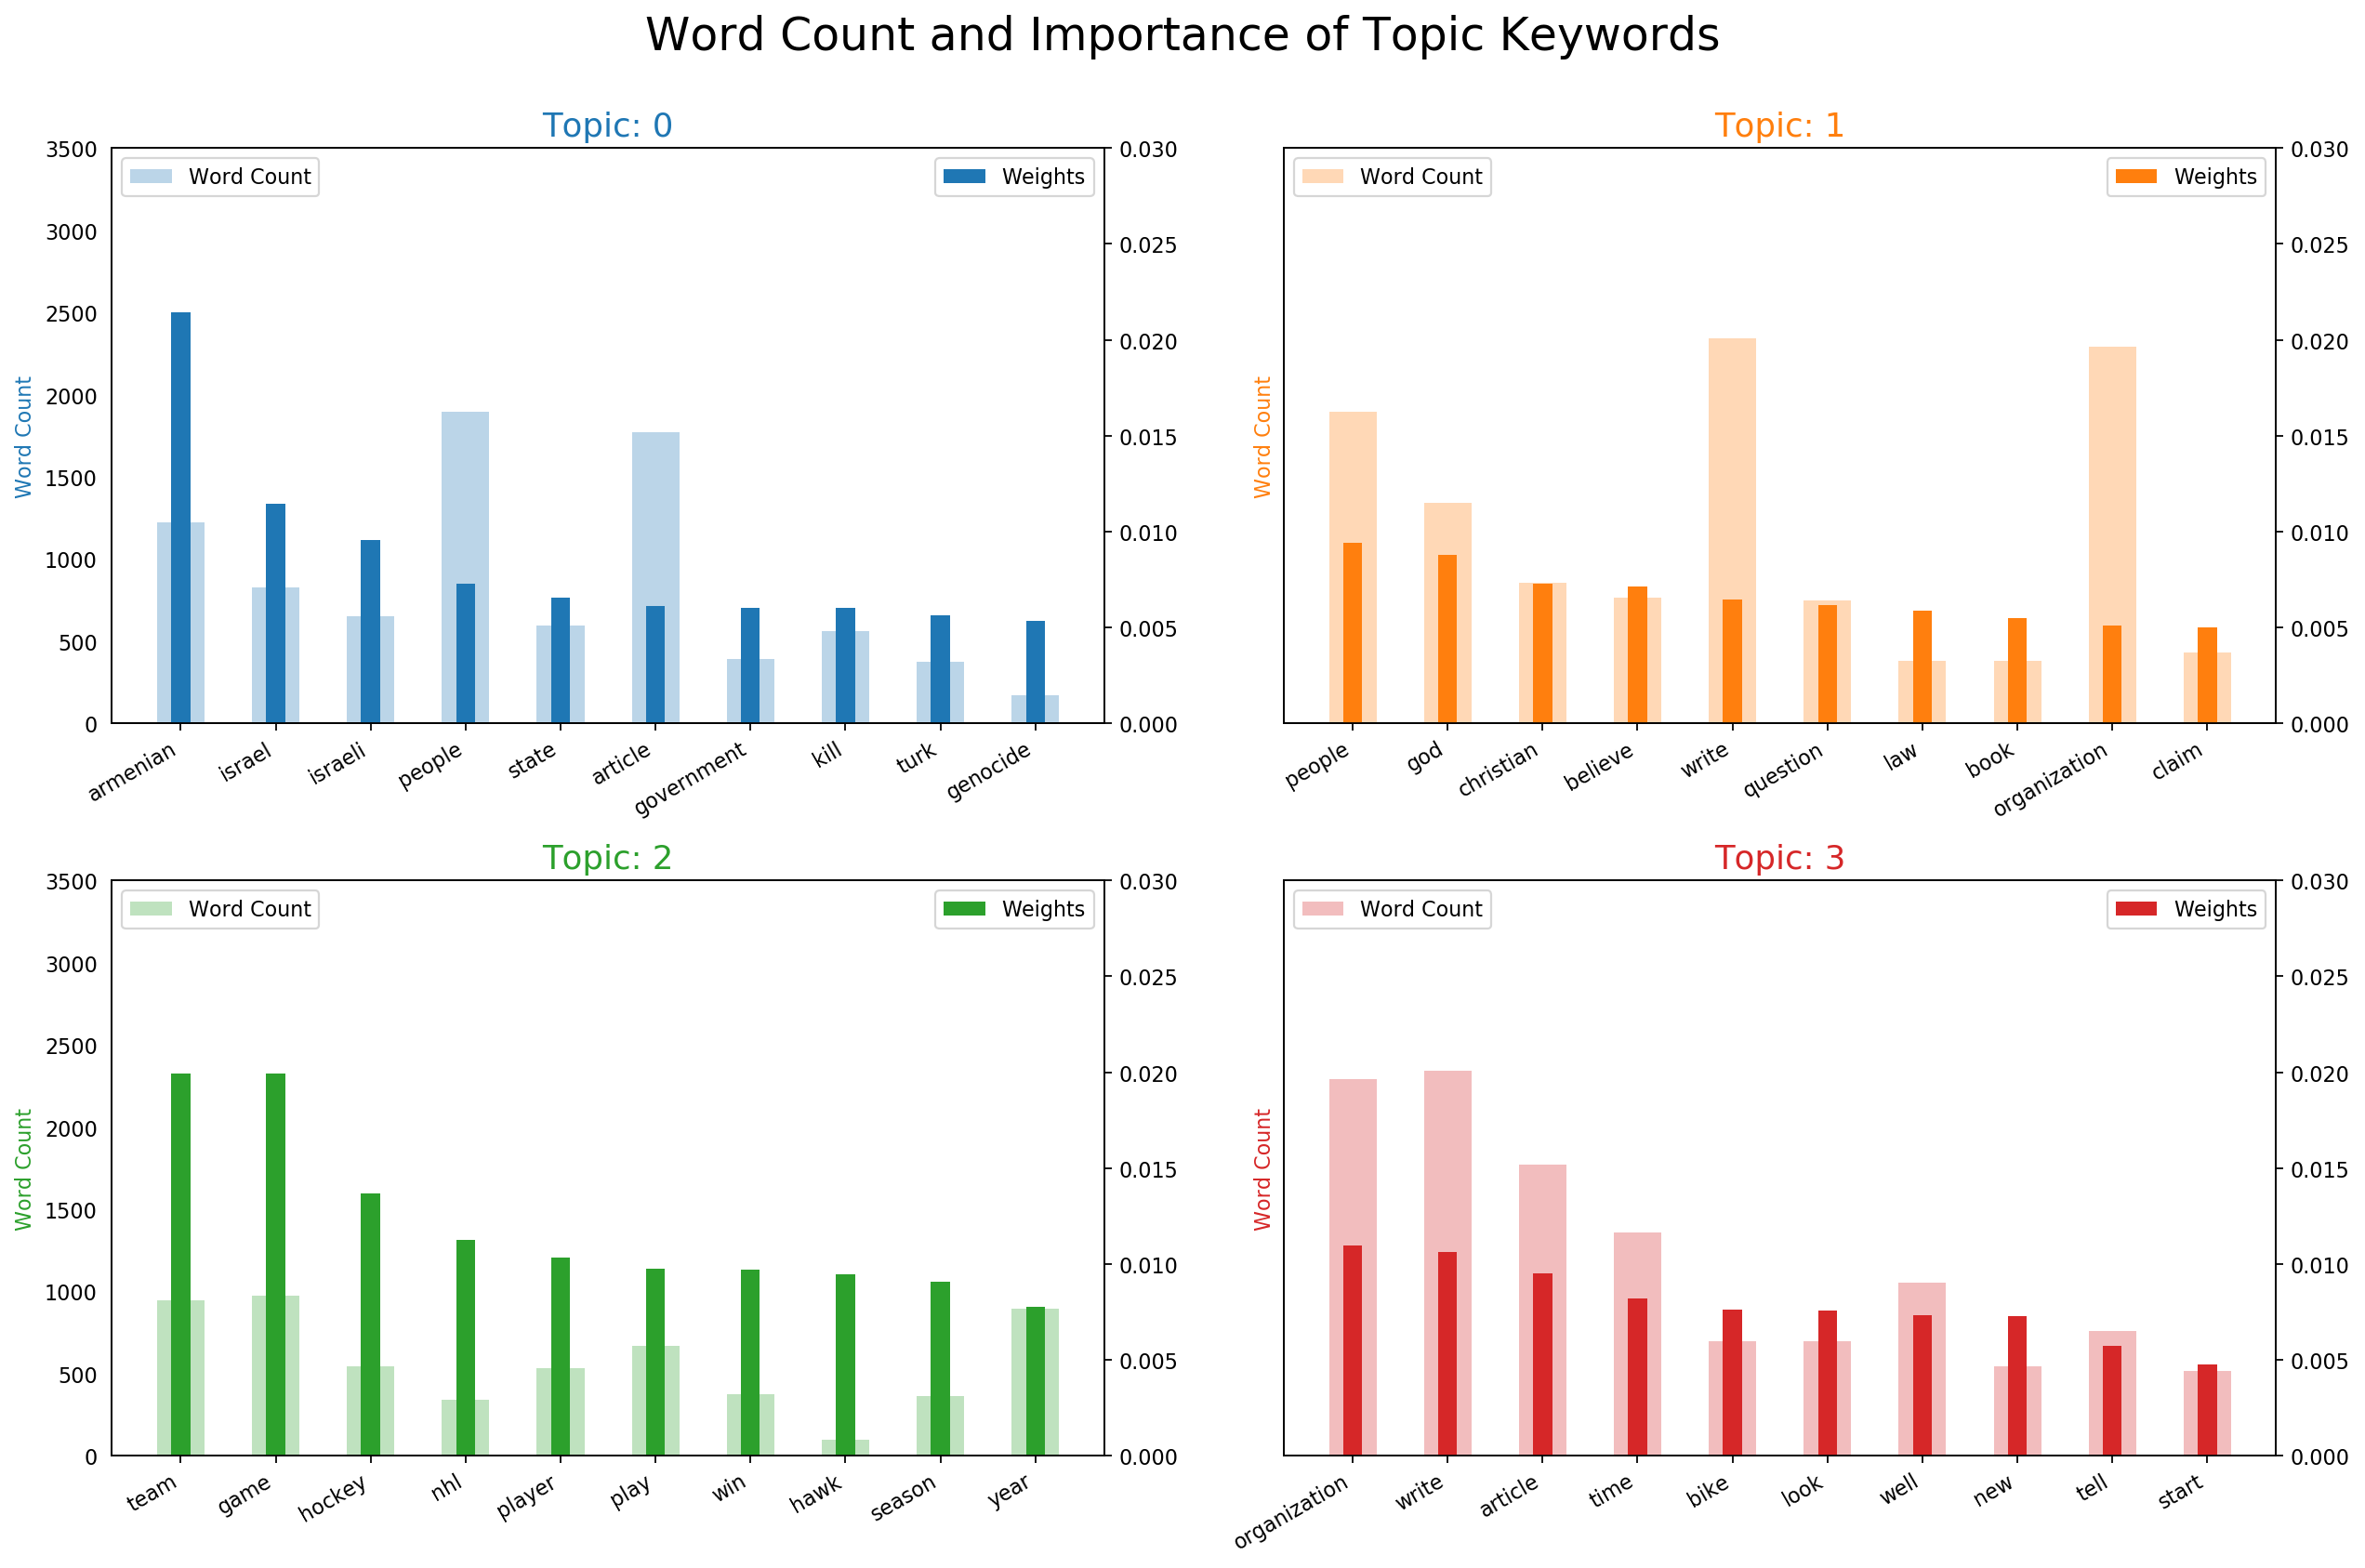

In [14]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### 11. Sentence Chart Colored by Topic

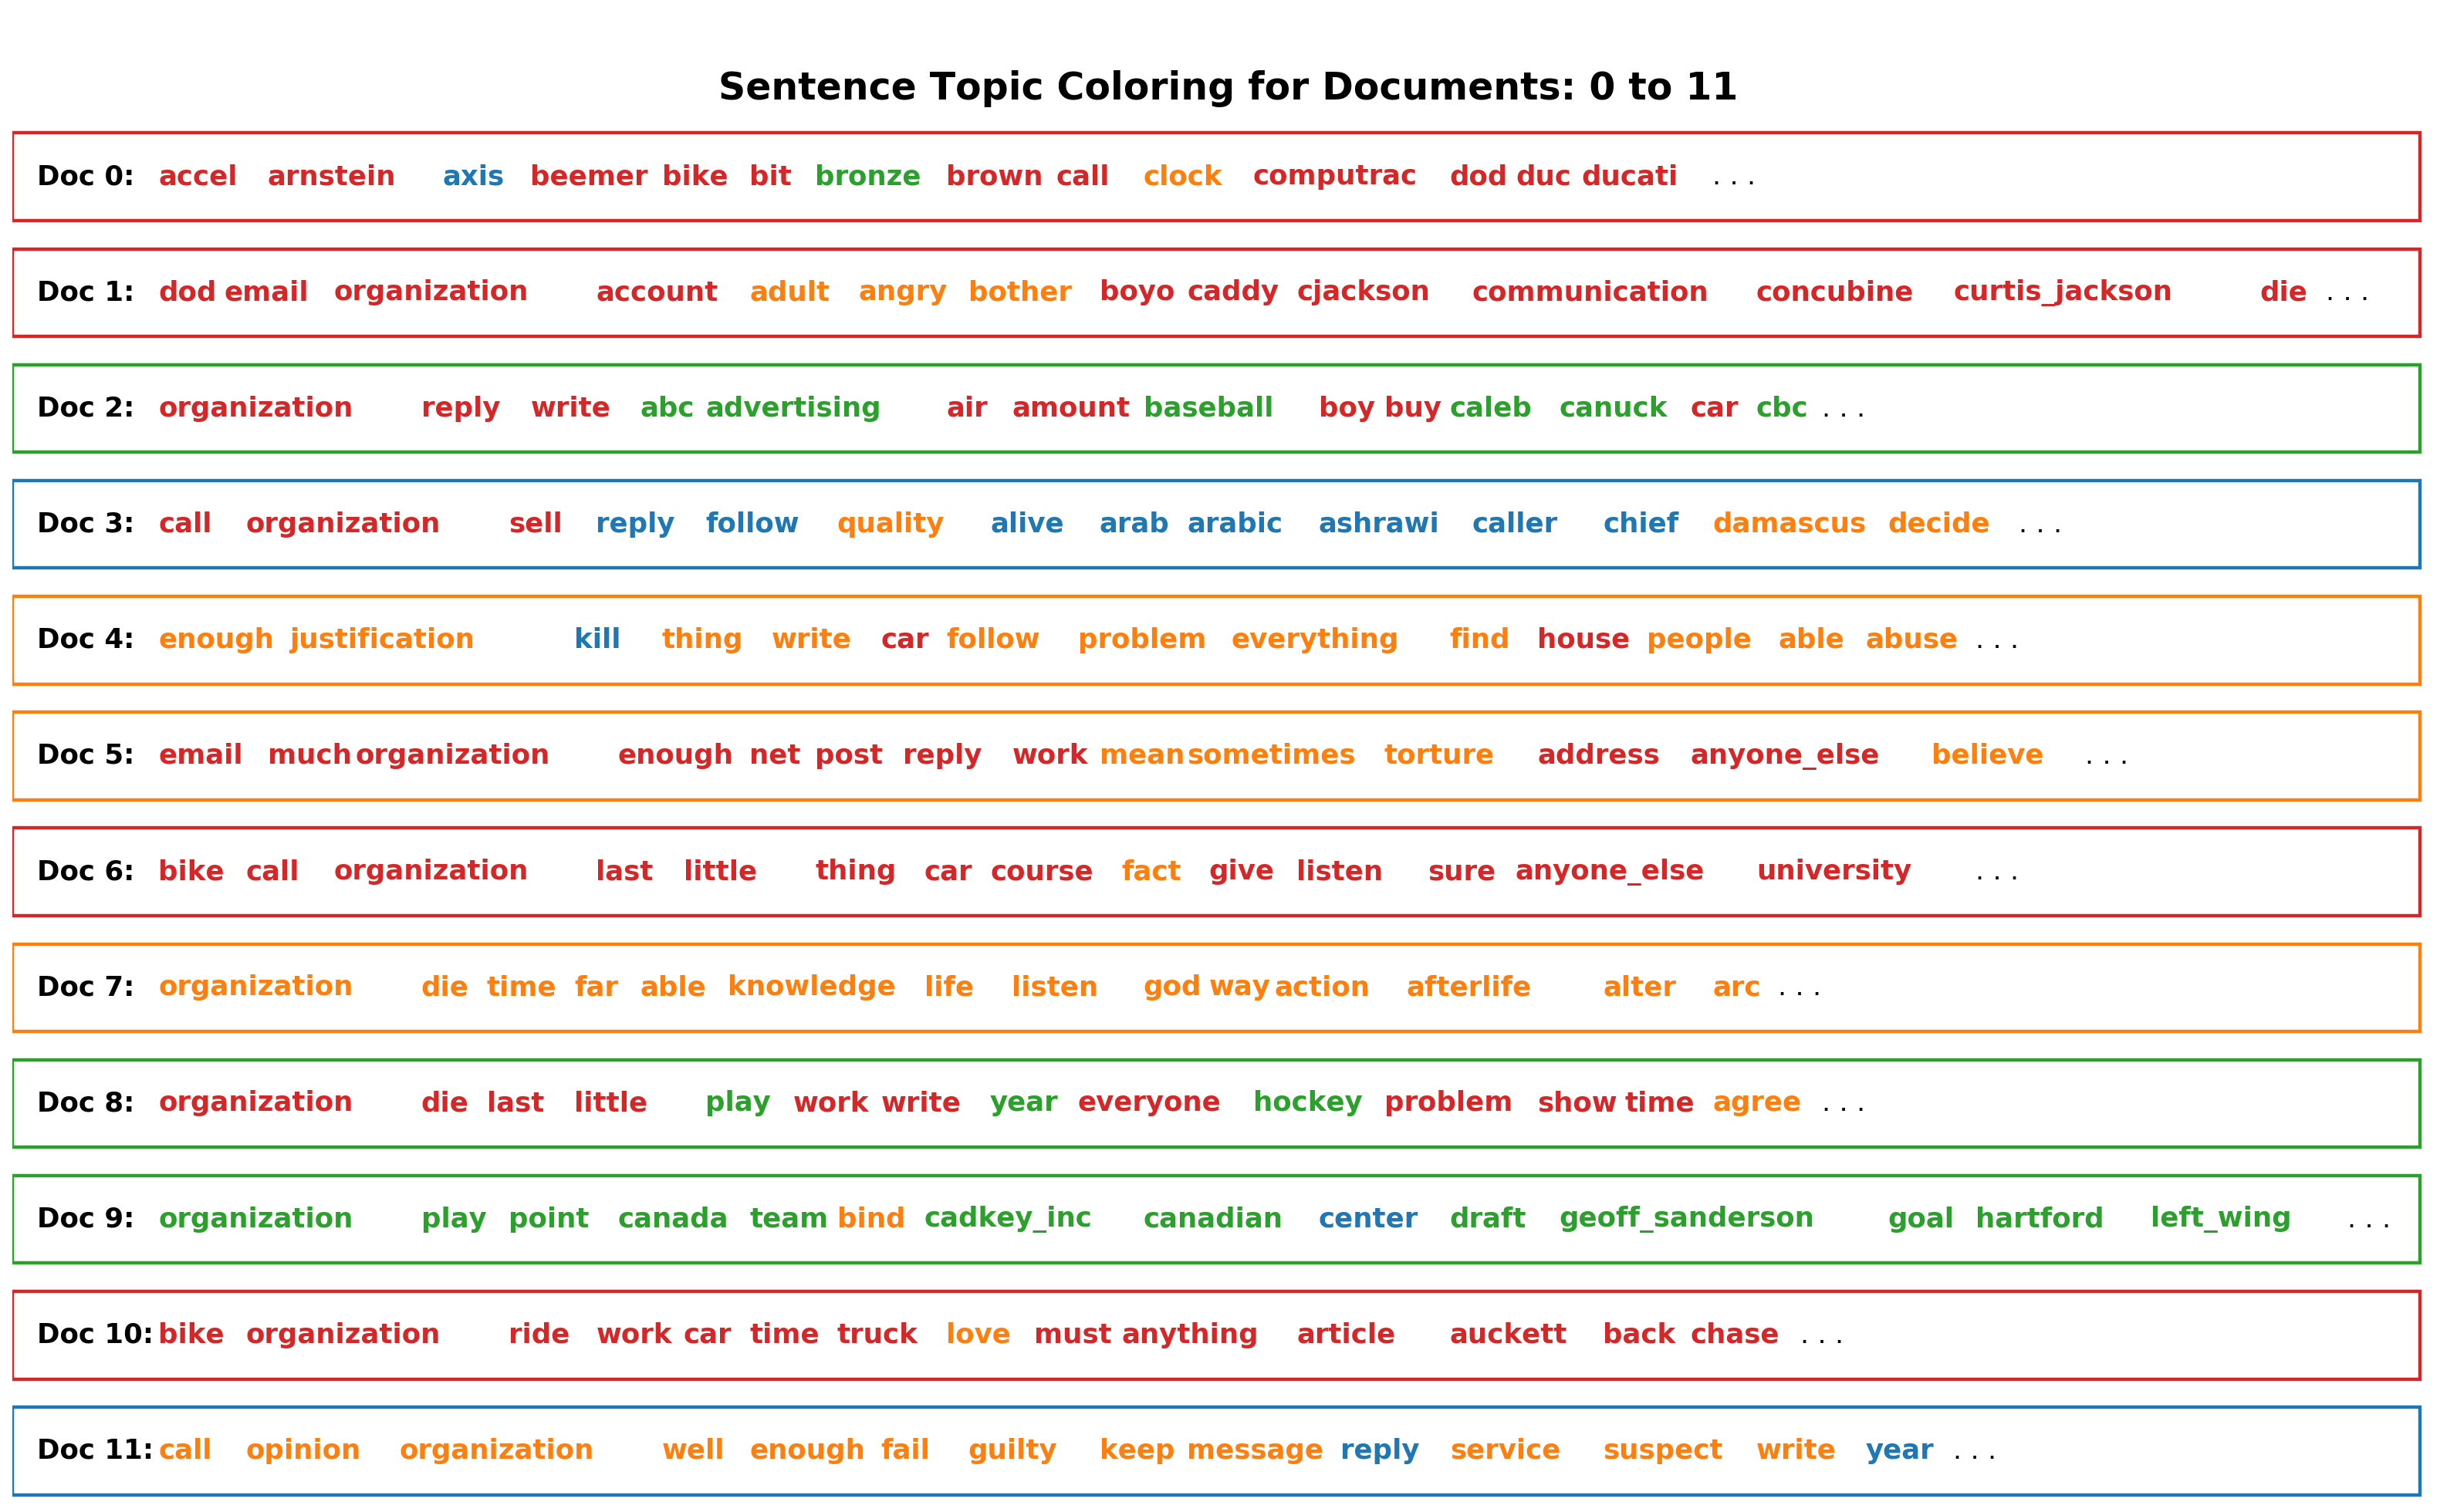

In [15]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()  

In [16]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

### 12. What are the most discussed topics in the documents?

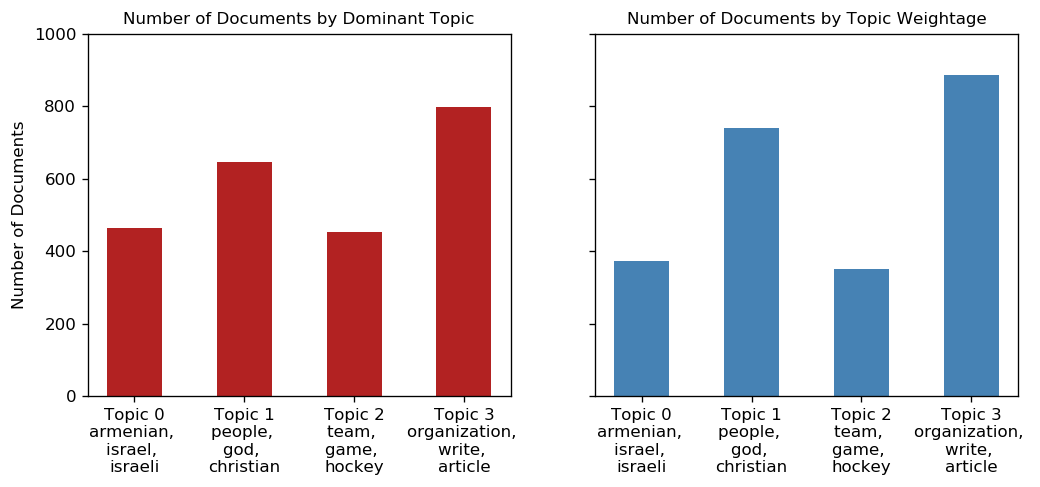

In [17]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

### 13. t-SNE Clustering Chart

In [19]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2353 samples in 0.003s...
[t-SNE] Computed neighbors for 2353 samples in 0.047s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2353
[t-SNE] Computed conditional probabilities for sample 2000 / 2353
[t-SNE] Computed conditional probabilities for sample 2353 / 2353
[t-SNE] Mean sigma: 0.023007
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.741753
[t-SNE] KL divergence after 1000 iterations: 0.479692


Loading BokehJS ...

### . pyLDAVis

In [20]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

C:\Users\b16z\Anaconda3\envs\deeplearning\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.176482 -0.091840       1        1  34.540714
3      0.071006 -0.171144       2        1  29.998123
0      0.095755  0.270224       3        1  21.722443
2     -0.343243 -0.007240       4        1  13.738714, topic_info=      Category         Freq          Term        Total  loglift  logprob
1479   Default  1453.000000      armenian  1453.000000  30.0000  30.0000
521    Default   856.000000          team   856.000000  29.0000  29.0000
1181   Default   855.000000          game   855.000000  28.0000  28.0000
707    Default   776.000000        israel   776.000000  27.0000  27.0000
155    Default   586.000000        hockey   586.000000  26.0000  26.0000
391    Default   944.000000           god   944.000000  25.0000  25.0000
2281   Default   648.000000       israeli   648.000000  24.0000  24.0000
1408   Default   483.000000           nhl   483.000000  23.0000  23.0000
2486   Default   444.000000        player   444.000000  22.0000  22.0000
4      Default   714.000000          bike   714.000000  21.0000  21.0000
467    Default   708.000000          look   708.000000  20.0000  20.0000
97     Default   420.000000          play   420.000000  19.0000  19.0000
524    Default   417.000000           win   417.000000  18.0000  18.0000
966    Default   784.000000     christian   784.000000  17.0000  17.0000
379    Default   769.000000       believe   769.000000  16.0000  16.0000
2906   Default   406.000000          hawk   406.000000  15.0000  15.0000
544    Default   389.000000        season   389.000000  14.0000  14.0000
719    Default   635.000000           law   635.000000  13.0000  13.0000
677    Default   409.000000    government   409.000000  12.0000  12.0000
1065   Default   591.000000          book   591.000000  11.0000  11.0000
324    Default   842.000000           new   842.000000  10.0000  10.0000
1644   Default   381.000000          turk   381.000000   9.0000   9.0000
272    Default   539.000000         claim   539.000000   8.0000   8.0000
49     Default  1000.000000          well  1000.000000   7.0000   7.0000
1542   Default   363.000000      genocide   363.000000   6.0000   6.0000
193    Default   354.000000          arab   354.000000   5.0000   5.0000
87     Default   491.000000          kill   491.000000   4.0000   4.0000
3065   Default   350.000000          page   350.000000   3.0000   3.0000
1645   Default   345.000000       turkish   345.000000   2.0000   2.0000
2477   Default   263.000000        league   263.000000   1.0000   1.0000
...        ...          ...           ...          ...      ...      ...
2906    Topic4   405.053314          hawk   406.816101   1.9806  -4.6623
10096   Topic4   154.446747            sj   155.127075   1.9806  -5.6265
4915    Topic4   154.124588           det   154.804688   1.9805  -5.6286
4960    Topic4   153.432098           pit   154.113174   1.9805  -5.6331
4983    Topic4   150.716583           tor   151.397110   1.9804  -5.6510
3894    Topic4   150.268082           stl   150.948090   1.9804  -5.6539
1275    Topic4   155.300858    pittsburgh   156.005783   1.9804  -5.6210
4903    Topic4   146.561722           buf   147.241135   1.9803  -5.6789
1376    Topic4   156.405502    defenseman   157.168152   1.9801  -5.6139
4468    Topic4   181.833435        norris   182.731750   1.9800  -5.4633
3741    Topic4   132.145920       detroit   132.830551   1.9798  -5.7825
4300    Topic4   144.606979           ahl   145.356186   1.9798  -5.6923
1901    Topic4   131.262161           chi   131.942581   1.9798  -5.7892
8461    Topic4   132.864197           har   133.556030   1.9798  -5.7770
1394    Topic4   132.465958           ice   133.169769   1.9797  -5.7800
8481    Topic4   127.393074           phi   128.074783   1.9796  -5.8191
4962    Topic4   125.813370           que   126.494011   1.9796  -5.8316
2135    Topic4   139.464523         coach   140.332184  